# Analysis
The key variable to judge success of offers and dependent variable for predictive modeling is incremental spend.
Other variables were considered, such as:
* Offer completion - will be looked at in the descriptives. Offer completion is a good proxy for how attractive consumers find an offer. However, from a business perspoective it is not as relevant as incremental spend, because it is possible that offers influence spend even when a consumer does not complete the offer. In addition, there is no offer completion for purely informational offers.
* Average hourly spend - A metric that considers the behavioural change (likely increase/potentially decrease in spend by the hour) during awareness. This can be compared to times when a consumer is not aware of any offer. As this metric does not factor in for *how long* a consumer sustains a higher level of spend, it does not tell the business what revenue it can make from an offer, though.
* Net total/incremental spend - A way to understand the net impact on the business better by deducting the reward amount from the total spend. However, this is a potentially poor proxy. For BOGO, it is unlikely that the consumer would have purchased two of the same product, and the cost to the company is hence not the revenue foregone, but the actual production cost of the product. In comparison, for the discount, the cost is the actual revenue foregone. There might also be other costs associated with the offers, like e.g. distribution cost. As costs are unknown, it was decided to work with incremental revenue.

These variables are contained in the analysis_df in case one wants to explore these variables further.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import json
import os
#% matplotlib inline
from pandasql import sqldf
from matplotlib import pyplot as plt

## Read in data and do some basic manipulation

In [4]:
# Save the file
analysis_df = pd.read_csv(r'2021_12_27_analysis_df.csv')

In [5]:
analysis_df.head(10)

,Unnamed: 0,person,block_id,hour,amount,hourly_avg,group,baseline_spend_during_awareness_time,incremental_spend,hourly_avg_during_nonawareness,...,time_lag_completion,time_lag_completion_to_expiry,gender,age,id,became_member_on,income,membership_duration,net_spend,net_spend_hourly_avg
0,0,0009655768c64bdeb2e877511632db8f,no_offer,604.0,96.87,0.160381,c,NaN,NaN,NaN,...,NaN,NaN,M,33,0009655768c64bdeb2e877511632db8f,2017-04-21,72000.0,-1711,96.87,0.160381
1,1,00116118485d4dfda04fdbaba9a87b5c,no_offer,574.0,4.09,0.007125,c,NaN,NaN,NaN,...,NaN,NaN,NaN,118,00116118485d4dfda04fdbaba9a87b5c,2018-04-25,NaN,-1342,4.09,0.007125
2,2,0011e0d4e6b944f998e987f904e8c1e5,no_offer,356.0,45.48,0.127753,c,NaN,NaN,NaN,...,NaN,NaN,O,40,0011e0d4e6b944f998e987f904e8c1e5,2018-01-09,57000.0,-1448,45.48,0.127753
3,3,0020c2b971eb4e9188eac86d93036a77,no_offer,586.0,161.99,0.276433,c,NaN,NaN,NaN,...,NaN,NaN,F,59,0020c2b971eb4e9188eac86d93036a77,2016-03-04,90000.0,-2124,161.99,0.276433
4,4,0020ccbbb6d84e358d3414a3ff76cffd,no_offer,536.0,58.68,0.109478,c,NaN,NaN,NaN,...,NaN,NaN,F,24,0020ccbbb6d84e358d3414a3ff76cffd,2016-11-11,60000.0,-1872,58.68,0.109478
5,5,003d66b6608740288d6cc97a6903f4f0,no_offer,472.0,17.42,0.036907,c,NaN,NaN,NaN,...,NaN,NaN,F,26,003d66b6608740288d6cc97a6903f4f0,2017-06-21,73000.0,-1650,17.42,0.036907
6,6,00426fe3ffde4c6b9cb9ad6d077a13ea,no_offer,604.0,19.25,0.031871,c,NaN,NaN,NaN,...,NaN,NaN,F,19,00426fe3ffde4c6b9cb9ad6d077a13ea,2016-08-09,65000.0,-1966,19.25,0.031871
7,7,004b041fbfe44859945daa2c7f79ee64,no_offer,550.0,90.51,0.164564,c,NaN,NaN,NaN,...,NaN,NaN,F,55,004b041fbfe44859945daa2c7f79ee64,2018-05-08,74000.0,-1329,90.51,0.164564
8,8,004c5799adbf42868b9cff0396190900,no_offer,597.0,245.44,0.411122,c,NaN,NaN,NaN,...,NaN,NaN,M,54,004c5799adbf42868b9cff0396190900,2016-03-31,99000.0,-2097,245.44,0.411122
9,9,0056df74b63b4298809f0b375a304cf4,no_offer,532.0,57.48,0.108045,c,NaN,NaN,NaN,...,NaN,NaN,M,54,0056df74b63b4298809f0b375a304cf4,2016-08-21,91000.0,-1954,57.48,0.108045


In [64]:
# Create a variable that identifies offers and gives some descriptive context:
# type_difficulty_reward_#channels
event_descriptor_dict = {'ae264e3637204a6fb9bb56bc8210ddfd':'bogo_10_10_3',
                        '0b1e1539f2cc45b7b9fa7c272da2e1d7':'disc_20_5_2',
                        '5a8bc65990b245e5a138643cd4eb9837':'info_0_0_2',
                        '3f207df678b143eea3cee63160fa8bed':'info_0_0_4',
                        '4d5c57ea9a6940dd891ad53e9dbe8da0':'bogo_10_10_4',
                        'f19421c1d4aa40978ebb69ca19b0e20d':'bogo_5_5_4',
                        'fafdcd668e3743c1bb461111dcafc2a4':'disc_10_2_4',
                        '2298d6c36e964ae4a3e7e9706d1fb8c2':'disc_7_3_4',
                        '2906b810c7d4411798c6938adc9daaa5':'disc_10_2_3',
                        '9b98b8c7a33c4b65b9aebfe6a799e6d9':'bogo_5_5_3'}

analysis_df['offer_descriptor'] = analysis_df['event_offer_id'].map(event_descriptor_dict)

#### Remove outliers of incremental spend
Rationale: For some respondents, there might have been very few days without awareness to establish a baseline spend. Or they might have happened to show unusual behaviour during the days that the offers were tested. Therefore, outliers should be removed. They would bias the data.


In [123]:
# TO DO

## Descriptive Analyses
The descriptive statistics below show that discounts get completed more frequently than BOGO offers. Nevertheless, it is a BOGO offer that, on average, has the highest incremental spend.
The data shows that only completed offers are, on average, associated with higher incremental spend. One could therefore argue that the company should try to only target consumers that are likely to complete an offer. However, as there will be costs associated with an offer, the further analysis will still be based on incremental spend to then give the company the flexibility to adjust thresholds of when a person will be sent an offer flexibly.

#### Check base sizes
to assure that for each group I am interested in, base sizes are large enough to draw conclusions

In [6]:
# Check base sizes for different offers
pd.DataFrame(analysis_df.groupby(['group']).size())

,0
group,
c,14913
t,49462


In [7]:
pd.DataFrame(analysis_df.groupby(['offer_type']).size())

,0
offer_type,
bogo,21403
discount,18283
informational,9776
no_offer,14913


In [65]:
pd.DataFrame(analysis_df.groupby(['offer_descriptor']).size())

,0
offer_descriptor,
bogo_10_10_3,5712
bogo_10_10_4,6377
bogo_5_5_3,3244
bogo_5_5_4,6070
disc_10_2_3,3306
disc_10_2_4,6390
disc_20_5_2,2320
disc_7_3_4,6267
info_0_0_2,6027


#### Understand offer completion
as an indicator for how attractive a BOGO and discount offer are to consumers.
Consumers do more often complete the discount than the BOGO offers.

In [67]:
# Create a pure treatment dataframe
analysis_df_t = analysis_df.loc[analysis_df['group'] == 't']

In [78]:
analysis_df_t[['offer_type','was_completed']].groupby(['offer_type']).mean()

,was_completed
offer_type,
bogo,0.443349
discount,0.617951
informational,0.000000


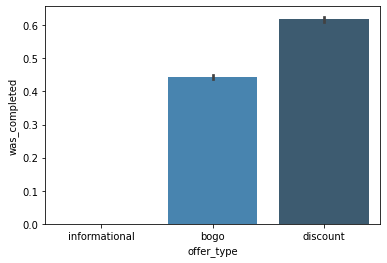

In [81]:
# How often do offers get completed (note: completion is not defined for informational offers)?
sns.barplot(x = analysis_df_t['offer_type'], y = analysis_df_t['was_completed'], palette="Blues_d");

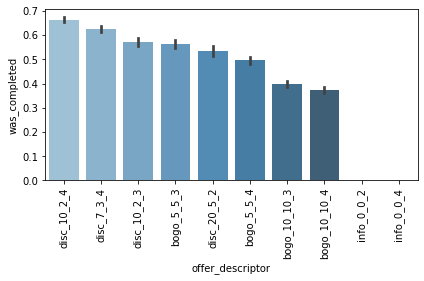

In [122]:
# Source Stackoverflow: https://stackoverflow.com/questions/31859285/rotate-tick-labels-for-seaborn-barplot
# Question by Laurennmc: https://stackoverflow.com/users/5198702/laurennmc
# Answer by wordsforthewise: https://stackoverflow.com/users/4549682/wordsforthewise

# Source for ordering is Stackoverflow: https://stackoverflow.com/questions/43770507/seaborn-bar-plot-ordering
# Question by vladkras: https://stackoverflow.com/users/1713660/vladkras
# Answer by Jeremy: https://stackoverflow.com/users/674301/jeremy

grp_order = analysis_df_t.groupby('offer_descriptor').was_completed.agg('mean').sort_values(ascending = False).index
sns.barplot(x = analysis_df_t['offer_descriptor'], y = analysis_df_t['was_completed'], order=grp_order, palette="Blues_d")
plt.xticks(rotation=90)
plt.tight_layout();

#### Understand incremental spend
to assess which offer type has the biggest impact on business revenue.
When plotting distributions, the graphs for BOGO and discount exhibit peaks at the difficulty level, i.e. the amount of money that needs to be spent to complete the offer. For informational offers, the graphs show more extreme maxima at/close to the origin, showing that many respondents did not change their behaviour as a consequency of the advertisement.

In [63]:
# Incremental spend
pd.DataFrame(analysis_df_t.groupby(['event_descriptor','offer_type','offer_difficulty', 'offer_reward', 'email', 'mobile','social','web'])['incremental_spend'].mean().reset_index().sort_values(by=['incremental_spend'], ascending = False))

,event_descriptor,offer_type,offer_difficulty,offer_reward,email,mobile,social,web,incremental_spend
0,bogo_10_10_3,bogo,10.0,10.0,1.0,1.0,1.0,0.0,6.050092
6,disc_20_5_2,discount,20.0,5.0,1.0,0.0,0.0,1.0,5.980005
8,info_0_0_2,informational,0.0,0.0,1.0,1.0,1.0,0.0,5.712367
9,info_0_0_4,informational,0.0,0.0,1.0,1.0,0.0,1.0,5.621588
1,bogo_10_10_4,bogo,10.0,10.0,1.0,1.0,1.0,1.0,5.418612
3,bogo_5_5_4,bogo,5.0,5.0,1.0,1.0,1.0,1.0,5.172055
5,disc_10_2_4,discount,10.0,2.0,1.0,1.0,1.0,1.0,4.958756
7,disc_7_3_4,discount,7.0,3.0,1.0,1.0,1.0,1.0,4.772336
4,disc_10_2_3,discount,10.0,2.0,1.0,1.0,0.0,1.0,4.540839
2,bogo_5_5_3,bogo,5.0,5.0,1.0,1.0,0.0,1.0,3.097809


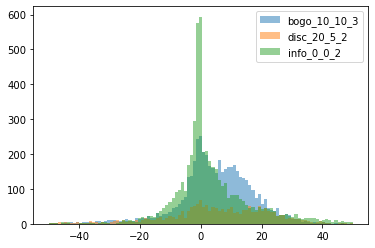

In [88]:
# Top 3 performing offers
# Source for overlayed charts: https://stackoverflow.com/questions/6871201/plot-two-histograms-on-single-chart-with-matplotlib
# Distribution of incremental spend
x = analysis_df_t.loc[analysis_df_t['event_descriptor'] == 'bogo_10_10_3']['incremental_spend']
y = analysis_df_t.loc[analysis_df_t['event_descriptor'] == 'disc_20_5_2']['incremental_spend']
z = analysis_df_t.loc[analysis_df_t['event_descriptor'] == 'info_0_0_2']['incremental_spend']

bins = np.linspace(-50, 50, 100)

plt.hist(x, bins, alpha=0.5, label='bogo_10_10_3')
plt.hist(y, bins, alpha=0.5, label='disc_20_5_2')
plt.hist(z, bins, alpha=0.5, label='info_0_0_2')
plt.legend(loc='upper right')
plt.show()

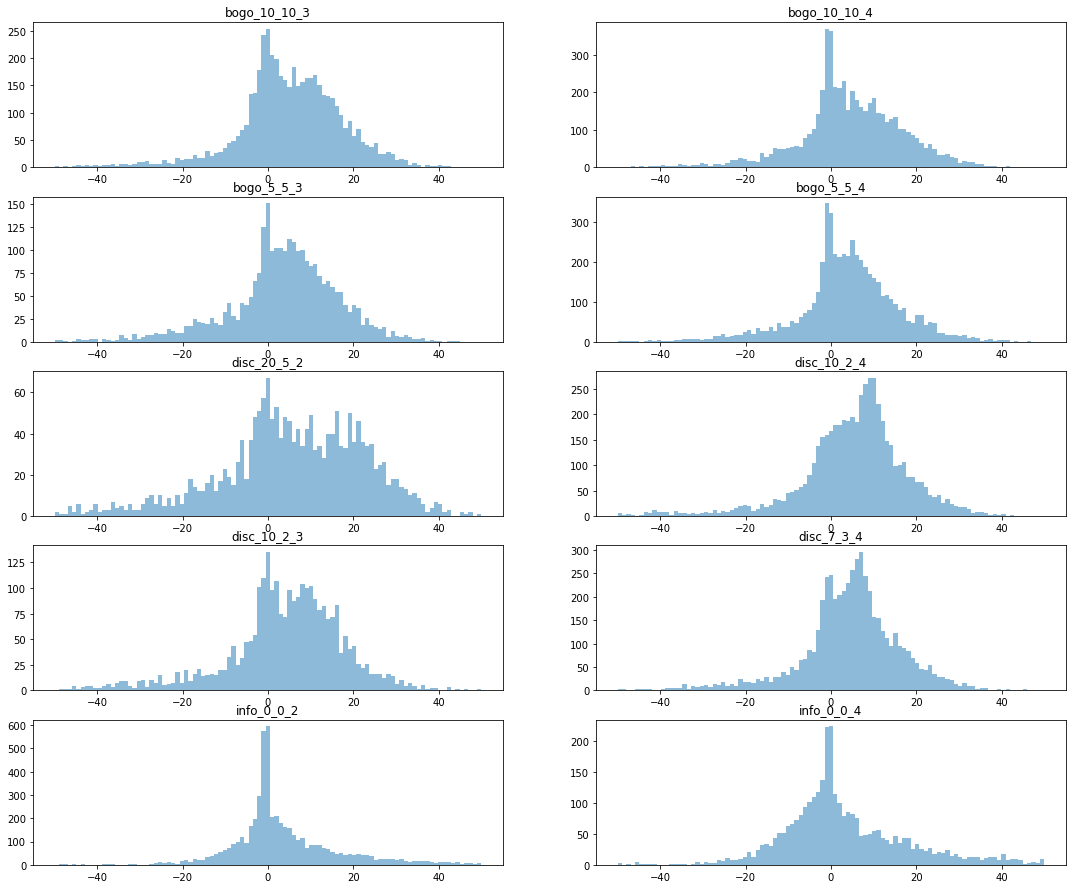

In [121]:
# Charting distributions of incremental spend
b1 = analysis_df_t.loc[analysis_df_t['event_descriptor'] == 'bogo_10_10_3']['incremental_spend']
b2 = analysis_df_t.loc[analysis_df_t['event_descriptor'] == 'bogo_10_10_4']['incremental_spend']
b3 = analysis_df_t.loc[analysis_df_t['event_descriptor'] == 'bogo_5_5_3']['incremental_spend']
b4 = analysis_df_t.loc[analysis_df_t['event_descriptor'] == 'bogo_5_5_4']['incremental_spend']
d1 = analysis_df_t.loc[analysis_df_t['event_descriptor'] == 'disc_20_5_2']['incremental_spend']
d2 = analysis_df_t.loc[analysis_df_t['event_descriptor'] == 'disc_10_2_4']['incremental_spend']
d3 = analysis_df_t.loc[analysis_df_t['event_descriptor'] == 'disc_10_2_3']['incremental_spend']
d4 = analysis_df_t.loc[analysis_df_t['event_descriptor'] == 'disc_7_3_4']['incremental_spend']
i1 = analysis_df_t.loc[analysis_df_t['event_descriptor'] == 'info_0_0_2']['incremental_spend']
i2 = analysis_df_t.loc[analysis_df_t['event_descriptor'] == 'info_0_0_4']['incremental_spend']

bins = np.linspace(-50, 50, 100)

fig, axs = plt.subplots(5,2) #,sharex=True, sharey=True)
fig.set_size_inches(18.5, 15.5)
ax_b1 = axs[0, 0].hist(b1, bins, alpha=0.5, label='bogo_10_10_3')
axs[0, 0].set_title('bogo_10_10_3')
ax_b2 = axs[0, 1].hist(b2, bins, alpha=0.5, label='bogo_10_10_4')
axs[0, 1].set_title('bogo_10_10_4')
ax_b3 = axs[1, 0].hist(b3, bins, alpha=0.5, label='bogo_5_5_3')
axs[1, 0].set_title('bogo_5_5_3')
ax_b4 = axs[1, 1].hist(b4, bins, alpha=0.5, label='bogo_5_5_4')
axs[1, 1].set_title('bogo_5_5_4')

ax_d1 = axs[2, 0].hist(d1, bins, alpha=0.5, label='disc_20_5_2')
axs[2, 0].set_title('disc_20_5_2')
ax_d2 = axs[2, 1].hist(d2, bins, alpha=0.5, label='disc_10_2_4')
axs[2, 1].set_title('disc_10_2_4')
ax_d3 = axs[3, 0].hist(d3, bins, alpha=0.5, label='disc_10_2_3')
axs[3, 0].set_title('disc_10_2_3')
ax_d4 = axs[3, 1].hist(d4, bins, alpha=0.5, label='disc_7_3_4')
axs[3, 1].set_title('disc_7_3_4')

ax_i1 = axs[4, 0].hist(i1, bins, alpha=0.5, label='info_0_0_2')
axs[4, 0].set_title('info_0_0_2')
ax_i2 = axs[4, 1].hist(i2, bins, alpha=0.5, label='info_0_0_4')
axs[4, 1].set_title('info_0_0_4');

#### Understand the impact of completion on incremental spend
to assess if simply knowing about an offer already leads to higher spend.
This is not the case. Average incremental spend is negative for those who do not complete the offer, meaning that these people spend less than they do when they are not aware of any offers.

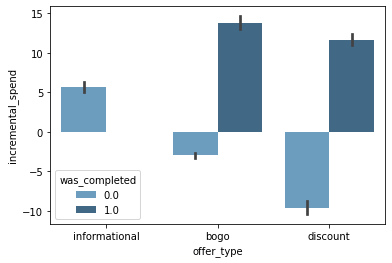

In [83]:
# Does only being aware of an offer w/o completing it also lead to positive incremental spend
sns.barplot(x = analysis_df_t['offer_type'], y = analysis_df_t['incremental_spend'], hue = analysis_df_t['was_completed'], palette="Blues_d");

## ANOVA
An ANOVA with post hoc tests is run to identify statistically significant differences in incremental spend between offers and to identify the most successful offer(s).

### Checking distributions

In [25]:
analysis_df_t

,Unnamed: 0,person,block_id,hour,amount,hourly_avg,group,baseline_spend_during_awareness_time,incremental_spend,hourly_avg_during_nonawareness,...,time_lag_completion,time_lag_completion_to_expiry,gender,age,id,became_member_on,income,membership_duration,net_spend,net_spend_hourly_avg
14913,14913,0009655768c64bdeb2e877511632db8f,1,61.0,8.570,0.140492,t,9.783228,-1.213228,0.160381,...,NaN,NaN,M,33,0009655768c64bdeb2e877511632db8f,2017-04-21,72000.0,-1711,8.570,0.140492
14914,14914,0009655768c64bdeb2e877511632db8f,2,49.0,22.160,0.452245,t,7.858659,14.301341,0.160381,...,NaN,NaN,M,33,0009655768c64bdeb2e877511632db8f,2017-04-21,72000.0,-1711,22.160,0.452245
14915,14915,00116118485d4dfda04fdbaba9a87b5c,5,73.0,0.000,0.000000,t,0.520157,-0.520157,0.007125,...,NaN,NaN,NaN,118,00116118485d4dfda04fdbaba9a87b5c,2018-04-25,NaN,-1342,0.000,0.000000
14916,14916,00116118485d4dfda04fdbaba9a87b5c,6,67.0,0.000,0.000000,t,0.477404,-0.477404,0.007125,...,NaN,NaN,NaN,118,00116118485d4dfda04fdbaba9a87b5c,2018-04-25,NaN,-1342,0.000,0.000000
14917,14917,0011e0d4e6b944f998e987f904e8c1e5,7,145.0,11.025,0.076034,t,18.524157,-7.499157,0.127753,...,144.0,72.0,O,40,0011e0d4e6b944f998e987f904e8c1e5,2018-01-09,57000.0,-1448,6.025,0.041552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64370,64370,fffad4f4828548d1b5583907f2e9906b,76269,31.0,6.970,0.224839,t,3.292786,3.677214,0.106219,...,30.0,84.0,M,34,fffad4f4828548d1b5583907f2e9906b,2017-01-23,34000.0,-1799,1.970,0.063548
64371,64371,fffad4f4828548d1b5583907f2e9906b,76270,7.0,12.180,1.740000,t,0.743532,11.436468,0.106219,...,6.0,12.0,M,34,fffad4f4828548d1b5583907f2e9906b,2017-01-23,34000.0,-1799,7.180,1.025714
64372,64372,ffff82501cea40309d5fdd7edcca4a07,76271,25.0,22.880,0.915200,t,7.112769,15.767231,0.284511,...,24.0,210.0,F,45,ffff82501cea40309d5fdd7edcca4a07,2016-11-25,62000.0,-1858,17.880,0.715200
64373,64373,ffff82501cea40309d5fdd7edcca4a07,76272,31.0,15.570,0.502258,t,8.819834,6.750166,0.284511,...,30.0,120.0,F,45,ffff82501cea40309d5fdd7edcca4a07,2016-11-25,62000.0,-1858,13.570,0.437742
